In [138]:
from pytrends.request import TrendReq

In [139]:
import pandas as pd
import time
import psycopg2 
import psycopg2.extras as extras
import matplotlib.pyplot as plt

In [140]:
df_raw = pd.read_excel("keytrends.xlsx", sheet_name='key_word')
#Thay the cot co ky tu / thanh _
df = df_raw.rename(columns=lambda b: b.replace("/ ","_"))
#df.head()

In [141]:
column_list = df.columns.ravel()
#print(column_list)

In [ ]:
# Tao file excel
df_db=[]
writer=pd.ExcelWriter('vn_trend_2020.xlsx', engine='xlsxwriter')
#lay du lieu tu google trend
pytrend = TrendReq(hl='vi-VN', tz=360, timeout=10)
for i in column_list:
    dataset = []
    keywords = list(df[i].dropna()) 
    for x in range(0,len(keywords)):
        keyword =[keywords[x]]
        pytrend.build_payload(
            kw_list=keyword,
            cat=0,
            timeframe='2019-01-01 2020-12-31',
            geo='VN',
            gprop=''
        )
        data=pytrend.interest_over_time()
        if not data.empty:
            data = data.drop(labels=['isPartial'],axis='columns')
            dataset.append(data)
    result=pd.concat(dataset,axis=1)
    result.to_excel(writer,sheet_name=i)
    
   #Tao dataframe cau truc giong voi DB 
    result.reset_index(level=0, inplace=True)
    df_melt=pd.melt(result, id_vars=["date"],var_name="Keywords", value_name="Value")
    df_melt['Trend_type'] = i   
    #result_final=pd.concat([df_melt],ignore_index=True)
    df_db.append(df_melt)
    
#Save excel 
writer.save()
df_db_final = pd.concat(df_db)

<h1> Insert dữ liệu vào postgresql và đưa kết quả top 10 keyword ra file</h1>

CREATE TABLE public.vn_trending
(
    "ID" integer NOT NULL DEFAULT nextval('"trending_ID_seq"'::regclass),
    date date,
    keywords character varying COLLATE pg_catalog."default",
    value bigint,
    trend_type character varying COLLATE pg_catalog."default",
    CONSTRAINT trending_pkey PRIMARY KEY ("ID")
)


In [77]:
try:
    print('Connecting to the PostgreSQL database...')
    conn=psycopg2.connect(
        host="localhost",
        database="GoogleTrend",
        user="postgres",
        password="Qu@ng@nh")
    
    cursor = conn.cursor()
    
    #truncate table
    cursor.execute('truncate table vn_trending')
    
    # Creating a list of tupples from the dataframe values
    tpls = [tuple(x) for x in df_db_final.to_numpy()]
    
    # dataframe columns with Comma-separated
    cols = ','.join(list(df_db_final.columns))
    
    # SQL query to execute
    sql = "INSERT INTO %s(%s) VALUES %%s" % ("vn_trending", cols)

    extras.execute_values(cursor, sql, tpls)
    conn.commit()
    print("Data inserted using execute_values() successfully..")

     ##select top 10
    # declare a cursor object from the connection

    sql_top = "select keywords, sum(Value) as sum_Value from vn_trending group by keywords order by sum(Value) desc limit 10"
    cursor.execute(sql_top)
    # Fetch all the records
    tuples = cursor.fetchall()
    # Preparing list of columns for dataframe
    df_top = pd.DataFrame(tuples,columns=['keywords','sum_Value'])
    print(df_top.head(100))
    ##Ghi ra excel
    df_top.to_excel('vn_trending_result.xls')
        
except (Exception, psycopg2.DatabaseError) as error:
    print(error)
#finally:
#    if conn is not None:
#        conn.close()
#        print('Database connection closed.')

Connecting to the PostgreSQL database...
Data inserted using execute_values() successfully..
             keywords sum_Value
0                Jack      3261
1          Tiêu Chiến      2150
2  Buồn Làm Chi Em Ơi      1999
3     Du lịch Đà Lạt       1919
4       Du lịch Sapa       1897
5    Du lịch Mộc Châu      1790
6    Du lịch Đà Nẵng       1777
7      Anh Thanh Niên      1765
8       Bánh Mì Không      1664
9  Du lịch Nha Trang       1619


<h1> Giai đoạn 3</h1>

<h2> Bài 1: Pivot table và xuất ra excel</h2>

In [78]:
writer1=pd.ExcelWriter('vn_trending_search_keyword_2020.xlsx', engine='xlsxwriter')
try:

    sql_distint ="select distinct trend_type from vn_trending"
    cursor.execute(sql_distint)
    lst_trend_type = cursor.fetchall()
   
    sql_distint=""
    for i in range(len(lst_trend_type)):
        sql_distint="""
                    select * 
                    from crosstab(
                            'select keywords,date_part(''month'',date) as Thang, sum(value) as giatri
                            from vn_trending
                            where date_part(''year'',date)='2020' trend_type=''"""+lst_trend_type[i][0]+"""''
                            group by keywords,date_part(''month'',date) ORDER BY 1',
                            'Select distinct date_part(''month'',date) as Thang from vn_trending where trend_type=''songs'' ORDER BY 1 '
                            ) as ct (
                              keywords text,
                              "Thang 1" bigint,
                              "Thang 2" bigint,
                              "Thang 3" bigint,
                              "Thang 4" bigint,
                              "Thang 5" bigint,
                              "Thang 6" bigint,
                              "Thang 7" bigint,
                              "Thang 8" bigint,
                              "Thang 9" bigint,
                              "Thang 10" bigint,
                              "Thang 11" bigint,
                              "Thang 12" bigint
                            );
                    """
        cursor.execute(sql_distint)
        columns_names = [ x[0] for x in cursor.description]
        rows = cursor.fetchall()
        df1 = pd.DataFrame(rows,columns=columns_names)
        df1.index += 1
        df1.index.name='STT'

        df1.to_excel(writer1,sheet_name=lst_trend_type[i][0],startrow=2)
        
        #Dăt tiêu đề cho các file excel
        ws=writer1.sheets[lst_trend_type[i][0]]
        
        merge_format = workbook.add_format({
                                            'bold': 1,
                                            'border': 0,
                                            'align': 'center',
                                            'valign': 'vcenter'})
        
        ws.merge_range('A1:N1', 'TỪ KHÓA TÌM KIẾM NHIỀU NHẤT TẠI VIỆT NAM',merge_format)
        ws.merge_range('A2:N2', 'NĂM 2020',merge_format)
        
    writer1.save()       
except (Exception, psycopg2.DatabaseError) as error:
    print(error)    

<h2> 2. Vẽ biểu đồ line chart top 5 trending các từ khóa tìm kiếm nhiều nhất 2020, xuất file ảnh top_search_key_2020.png</h2>


<h3>2.1. Lấy dữu liệu từ DB ra dataframe</h3>

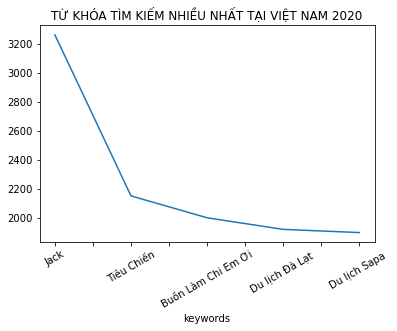

<Figure size 432x288 with 0 Axes>

In [143]:
import matplotlib.pyplot as plt
sql_top5 ="select keywords, sum(value) as giatri from vn_trending where date_part('year',date)='2020' group by keywords order by sum(value) desc limit 5"
cursor.execute(sql_top5)
#chuyển thành dataframe
columns_names = [ x[0] for x in cursor.description]
rows = cursor.fetchall()
df_top5 = pd.DataFrame(rows,columns=columns_names)
df_top5=df_top5.astype({"giatri":'int64'}) 
df_top5.plot(x ='keywords', y='giatri', 
            kind = 'line',
             title ='TỪ KHÓA TÌM KIẾM NHIỀU NHẤT TẠI VIỆT NAM 2020',
             rot=30, 
             fontsize=10,
            legend=False)

plt.show()
plt.savefig('top_search_key_2020.png')


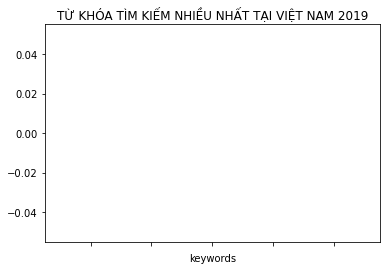

<Figure size 432x288 with 0 Axes>

In [145]:
import matplotlib.pyplot as plt
sql_top5 ="select keywords, sum(value) as giatri from vn_trending where date_part('year',date)='2019' group by keywords order by sum(value) desc limit 5"
cursor.execute(sql_top5)
#chuyển thành dataframe
columns_names = [ x[0] for x in cursor.description]
rows = cursor.fetchall()
df_top5 = pd.DataFrame(rows,columns=columns_names)
df_top5=df_top5.astype({"giatri":'int64'}) 
df_top5.plot(x ='keywords', y='giatri', 
            kind = 'line',
             title ='TỪ KHÓA TÌM KIẾM NHIỀU NHẤT TẠI VIỆT NAM 2019',
             rot=30, 
             fontsize=10,
            legend=False)

plt.show()
plt.savefig('top_search_key_2019.png')
